In [1]:
import torch
from torch import nn
from uniphm.data import Dataset, TurbofanRulLabeler
from uniphm.data.loader.CMAPSSLoader import CMAPSSLoader
from uniphm.data.process.array.NormalizationProcessor import NormalizationProcessor
from uniphm.engine.Evaluator import Evaluator
from uniphm.engine.metric.MSE import MSE
from uniphm.engine.metric.MAE import MAE
from uniphm.engine.metric.PHM2008Score import PHM2008Score
from uniphm.engine.metric.PHM2012Score import PHM2012Score
from uniphm.engine.metric.PercentError import PercentError
from uniphm.engine.metric.RMSE import RMSE
from uniphm.engine.tester.BaseTester import BaseTester
from uniphm.engine.trainer.BaseTrainer import BaseTrainer
from uniphm.model.classic.Transfromer import TransformerEncoderModel
from uniphm.engine.callback.CheckGradientsCallback import CheckGradientsCallback
from uniphm.engine.callback.EarlyStoppingCallback import EarlyStoppingCallback
from uniphm.engine.callback.TensorBoardCallback import TensorBoardCallback
from uniphm.util.Cache import Cache
from uniphm.util.Plotter import Plotter

In [2]:
cache_model = False
Plotter.DPI = 40
Plotter.SIZE = (4, 2.4)

# 基本信息

In [3]:
data_loader = CMAPSSLoader('D:\\data\\dataset\\CMAPSSData')
sensor = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRF', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
sensor_norm = ['norm_' + s for s in sensor]

[DEBUG   17:24:22]  
[DataLoader]  Root directory: D:\data\dataset\CMAPSSData
	✓ FD001_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD001.txt
	✓ FD002_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD002.txt
	✓ FD003_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD003.txt
	✓ FD004_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD004.txt
	✓ FD001_test, location: D:\data\dataset\CMAPSSData\test_FD001.txt
	✓ FD002_test, location: D:\data\dataset\CMAPSSData\test_FD002.txt
	✓ FD003_test, location: D:\data\dataset\CMAPSSData\test_FD003.txt
	✓ FD004_test, location: D:\data\dataset\CMAPSSData\test_FD004.txt
	✓ FD001_train, location: D:\data\dataset\CMAPSSData\train_FD001.txt
	✓ FD002_train, location: D:\data\dataset\CMAPSSData\train_FD002.txt
	✓ FD003_train, location: D:\data\dataset\CMAPSSData\train_FD003.txt
	✓ FD004_train, location: D:\data\dataset\CMAPSSData\train_FD004.txt


# 发动机数据可视化

In [25]:
turbofan = data_loader('FD001_train_1', include=sensor)

[INFO    17:32:17]  [DataLoader]  -> Loading data entity: FD001_train_1
[INFO    17:32:17]  [DataLoader]  ✓ Successfully loaded: FD001_train_1


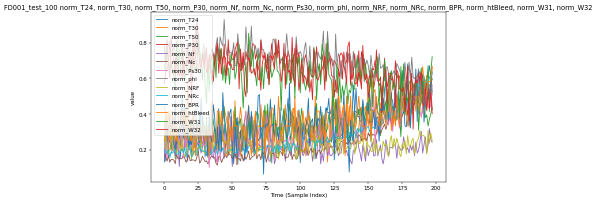

'default'

In [23]:
Plotter.SIZE = (8, 5)
Plotter.entity(turbofan, sensor_norm)

# 配置标签器

In [6]:
labeler_all_sample = TurbofanRulLabeler(window_size=30, window_step=1, max_rul=130)
labeler_last_sample = TurbofanRulLabeler(window_size=30, window_step=1, max_rul=130, last_sample=True)

# 加载训练集

In [7]:
turbofans_train = data_loader.batch_load('FD001_train', include=sensor)
train_set = Dataset()
for turbofan in turbofans_train:
    train_set.append_entity(labeler_all_sample(turbofan, sensor_norm))
train_set.name = 'FD001_train'

[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_1
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_1
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_2
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_2
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_3
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_3
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_4
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_4
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_5
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_5
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_6
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_6
[INFO    17:24:24]  [DataLoader]  -> Loading data entity: FD001_train_7
[INFO    17:24:24]  [DataLoader]  ✓ Successfully loaded: FD001_train_7

# 加载测试集

In [8]:
turbofan_test = data_loader.batch_load('FD001_test', include=sensor)
test_set_last_sample = Dataset()
test_set_all_sample = Dataset()
for turbofan in turbofan_test:
    test_set_last_sample.append_entity(labeler_last_sample(turbofan, sensor_norm))
    test_set_all_sample.append_entity(labeler_all_sample(turbofan, sensor_norm))
test_set_last_sample.name = 'FD001_test'

[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_1
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_1
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_2
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_2
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_3
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_3
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_4
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_4
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_5
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_5
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_6
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_6
[INFO    17:24:25]  [DataLoader]  -> Loading data entity: FD001_test_7
[INFO    17:24:25]  [DataLoader]  ✓ Successfully loaded: FD001_test_7
[INFO    17:2

# 标签归一化训练能显著降低梯度消失的概率

In [9]:
norm = NormalizationProcessor(arr_min=0, arr_max=130, mode='[0,1]')

# 配置测试算法

In [10]:
test_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'norm': norm
}
tester = BaseTester(config=test_config)

# 配置训练算法

In [11]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 120,
    'batch_size': 512,
    'lr': 0.01,
    'weight_decay': 0.01,
    'criterion': nn.MSELoss(),
    'norm': norm,
    'callbacks': [
        EarlyStoppingCallback(patience=20,
                              val_set=train_set,
                              metric=RMSE(),
                              tester=tester),
        CheckGradientsCallback(),
        TensorBoardCallback()]
}
trainer = BaseTrainer(config=train_config)

# 加载模型

[INFO    17:24:27]  
[Trainer]  Start training by BaseTrainer:
	training set: FD001_train
	device: cuda
	dtype: torch.float32
	epochs: 120
	batch_size: 512
	lr: 0.01
	weight_decay: 0.01
	criterion: MSELoss()
	norm: NormalizationProcessor(min=0, max=130, mean=None, std=None, mode=[0,1])
	callbacks: [EarlyStoppingCallback, CheckGradientsCallback, TensorBoardCallback]
	optimizer: Adam
[DEBUG   17:24:28]  [EarlyStopping]  On the validation set FD001_train, the RMSE is 43.4888
[INFO    17:24:29]  [BaseTrainer]  Epoch [1/120], MSELoss:13141.5850
[DEBUG   17:24:29]  [EarlyStopping]  On the validation set FD001_train, the RMSE is 44.8702
[DEBUG   17:24:29]  [EarlyStopping]  No improvement for [1/20] epochs
[WARNING 17:24:29]  [CheckGradients] output_linear.weight gradient is very large: 1.14e+03
[WARNING 17:24:29]  [CheckGradients] output_linear.bias gradient is very large: 1.52e+03
[INFO    17:24:30]  [BaseTrainer]  Epoch [2/120], MSELoss:1932.9805
[DEBUG   17:24:31]  [EarlyStopping]  On the 

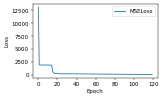

[DEBUG   17:27:53]  [Cache]  Generating cache file: .\cache\CMAPSS_model.pkl
[DEBUG   17:27:53]  [Cache]  Generated cache file: .\cache\CMAPSS_model.pkl


In [12]:
model = Cache.load('CMAPSS_model', cache_model)
if model is None:
    model = TransformerEncoderModel(14, 1)

    # 开始训练
    loss_history_dicts = trainer(model=model, train_set=train_set)
    Plotter.SIZE = (4, 2.4)
    Plotter.loss(loss_history_dicts)
    Cache.save(model, 'CMAPSS_model')

# 配置评价指标与评价器

In [13]:
evaluator = Evaluator(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())

# 仅测试最后一个时间窗口

In [14]:
result_last_sample = tester(model, test_set_last_sample)
evaluator(test_set_last_sample, result_last_sample, title='Evaluation of last sample')

[INFO    17:27:53]  
[Evaluator]  Evaluation of last sample:
                    MAE        MSE     RMSE PercentError PHM2012Score PHM2008Score
FD001_test_1     9.6379    92.8893   9.6379       -8.61%       0.3033       1.6216
FD001_test_2    27.3118   745.9368  27.3118      -27.87%       0.0210      14.3511
FD001_test_3    26.9344   725.4608  26.9344       39.04%       0.2585       6.9397
FD001_test_4     5.0500    25.5030   5.0500       -6.16%       0.4258       0.6570
FD001_test_5    20.3956   415.9820  20.3956       22.41%       0.4599       3.8013
FD001_test_6    34.0195  1157.3244  34.0195      -36.58%       0.0063      29.0225
FD001_test_7    10.6723   113.8990  10.6723      -11.73%       0.1967       1.9073
FD001_test_8    20.3683   414.8677  20.3683       21.44%       0.4757       3.7913
FD001_test_9    15.7529   248.1553  15.7529      -14.19%       0.1398       3.8322
FD001_test_10   13.8170   190.9085  13.8170      -14.39%       0.1360       2.9817
FD001_test_11    5.1541   

,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
FD001_test_1,9.6379,92.8893,9.6379,-8.61%,0.3033,1.6216
FD001_test_2,27.3118,745.9368,27.3118,-27.87%,0.0210,14.3511
FD001_test_3,26.9344,725.4608,26.9344,39.04%,0.2585,6.9397
FD001_test_4,5.0500,25.5030,5.0500,-6.16%,0.4258,0.6570
FD001_test_5,20.3956,415.9820,20.3956,22.41%,0.4599,3.8013
...,...,...,...,...,...,...
FD001_test_98,21.3387,455.3407,21.3387,-36.17%,0.0066,7.4475
FD001_test_99,11.3612,129.0777,11.3612,-9.71%,0.2602,2.1147
FD001_test_100,0.6821,0.4652,0.6821,-3.41%,0.6233,0.0706
mean(global),12.0597,257.1194,16.0349,-2.96%,0.3636,413.3910


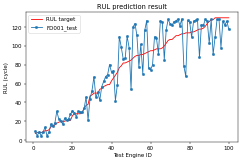

'RUL prediction result'

In [29]:
Plotter.SIZE = (6, 4)
Plotter.rul_ascending(test_set_last_sample, result_last_sample,
                      is_scatter=False, label_x='Test Engine ID', label_y='RUL (cycle)')

# 测试所有时间窗口

In [16]:
result_all_sample = tester(model, test_set_all_sample)
evaluator(test_set_all_sample, result_all_sample, title='Evaluation of all sample')

[INFO    17:27:54]  
[Evaluator]  Evaluation of all sample:
                    MAE        MSE     RMSE PercentError PHM2012Score PHM2008Score
FD001_test_1    11.3505   131.7666  11.4790      -10.09%       0.2524       4.3141
FD001_test_2    16.7381   326.0165  18.0559      -15.18%       0.1890     112.4092
FD001_test_3    18.2364   527.7001  22.9717        0.68%       0.4527     875.3266
FD001_test_4    12.0278   346.1278  18.6045       -9.17%       0.5544     794.7071
FD001_test_5    10.4751   175.3800  13.2431        2.08%       0.6051     156.1480
FD001_test_6     5.2694    78.7502   8.8741       -1.61%       0.7706     121.1735
FD001_test_7     3.9365    39.0537   6.2493       -0.67%       0.8116      89.7536
FD001_test_8     8.1629   173.9248  13.1881        2.64%       0.7437     378.1149
FD001_test_9     6.6836    65.0692   8.0665        0.48%       0.7233      26.3220
FD001_test_10   10.7523   258.7946  16.0871        7.25%       0.7520     513.0746
FD001_test_11   13.9834   2

,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
FD001_test_1,11.3505,131.7666,11.4790,-10.09%,0.2524,4.3141
FD001_test_2,16.7381,326.0165,18.0559,-15.18%,0.1890,112.4092
FD001_test_3,18.2364,527.7001,22.9717,0.68%,0.4527,875.3266
FD001_test_4,12.0278,346.1278,18.6045,-9.17%,0.5544,794.7071
FD001_test_5,10.4751,175.3800,13.2431,2.08%,0.6051,156.1480
...,...,...,...,...,...,...
FD001_test_98,22.5013,788.6590,28.0831,-1.54%,0.3833,2040.6354
FD001_test_99,2.2587,10.4289,3.2294,0.19%,0.8919,17.8089
FD001_test_100,4.9696,50.8545,7.1312,1.91%,0.7483,120.9038
mean(global),11.4908,291.2295,17.0654,0.96%,0.5991,88132.3959


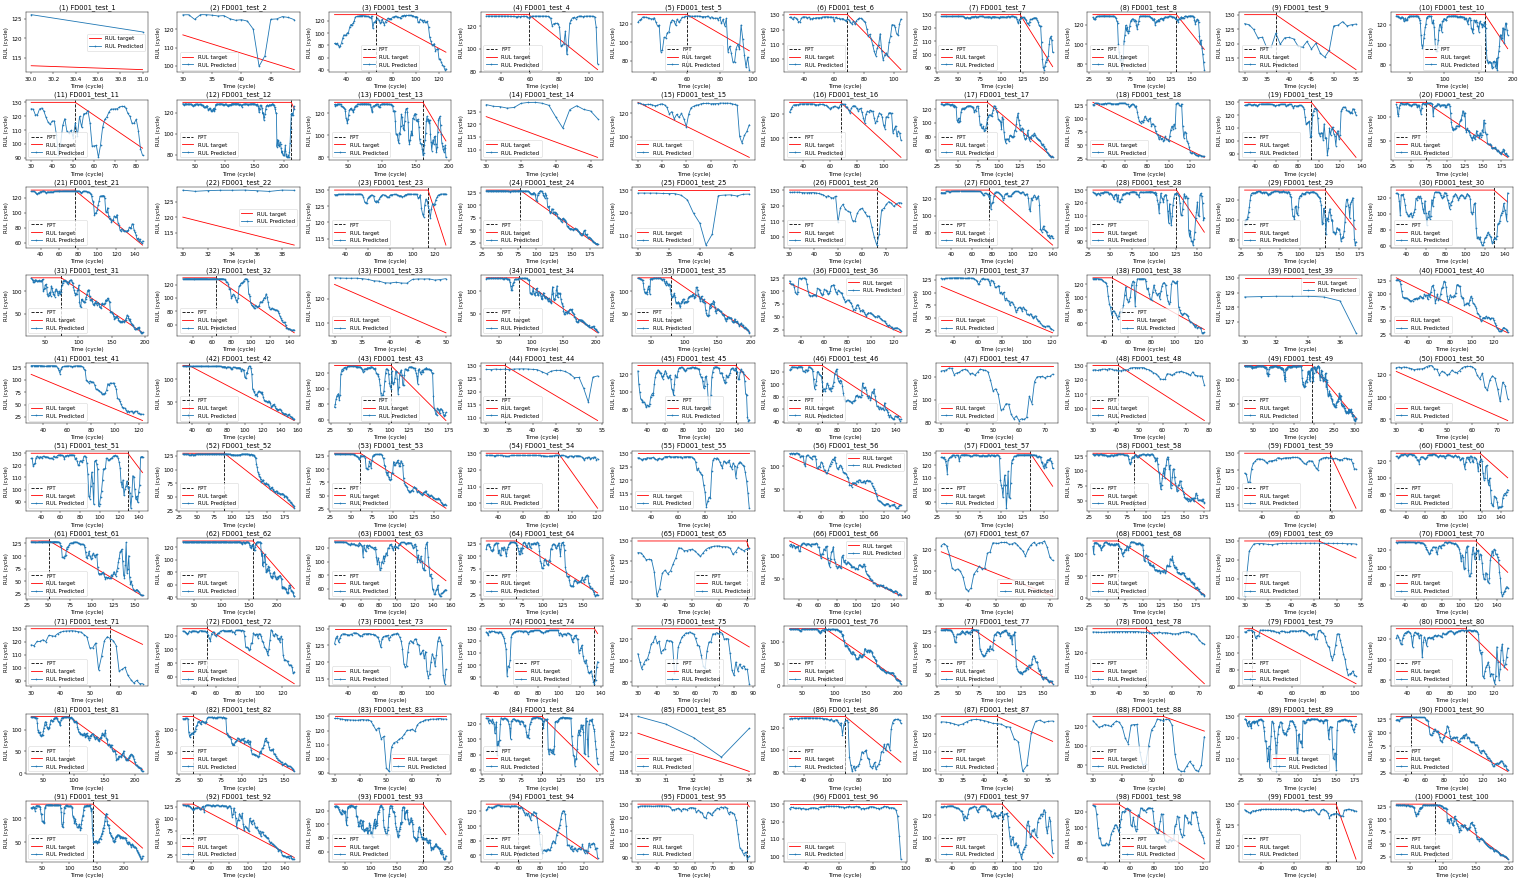

'default'

In [28]:
Plotter.SIZE = (3.8, 2.2)
Plotter.rul_end2end(test_set_all_sample, result_all_sample,
                    is_scatter=False, label_x='Time (cycle)', label_y='RUL (cycle)')

# 仅绘图某个发动机预测结果

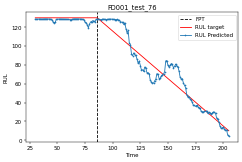

'default'

In [27]:
Plotter.SIZE = (6, 4)
Plotter.rul_end2end(test_set_all_sample.get('FD001_test_76'), result_all_sample.get('FD001_test_76'),
                    is_scatter=False)